In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from tqdm import tqdm


In [ ]:
def generate_data(m, n, algorithm='perceptron'):
    # m data points, n dimensions
    raw_data = np.random.randint(0, 2, size=(m, n)) # x in {0,1}
    if algorithm == 'winnow':
        X = raw_data 
    else:
        X = 2*raw_data - 1  # Convert to x in {-1,1}
    y = X[:,0]
    return X, y

In [73]:
def train_perceptron(X_train, y_train, max_iters):
    m, n = X_train.shape 
    w = np.zeros(n) # weights initialised to zero, size equal to number of dimensions
    for iter in range(max_iters):
        mistakes = 0
        for i in range(m):

            y_true = y_train[i]
            x = X_train[i]

            # Prediction Step
            y_pred = 1 if np.dot(w, x) >= 0 else -1

            # Update Step
            if y_pred != y_true:
                w = w + y_true * x
                mistakes += 1

        if mistakes == 0: break # no more learning
    return w

def train_winnow(X_train, y_train, max_iters):
    m, n = X_train.shape 
    w = np.ones(n, dtype='float') # weights initialised to one, size equal to number of dimensions
    for iter in range(max_iters):
        mistakes = 0
        for i in range(m):

            y_true = y_train[i]
            x = X_train[i]

            # Prediction Step
            y_pred = 1 if np.dot(w, x) >= n else 0

            # Update Step
            if y_pred != y_true:
                w = w * 2.0 ** ((y_true - y_pred)*x)
                mistakes += 1

        if mistakes == 0: break # no more learning
    return w

def train_least_squares(X_train, y_train):
    # solving the normal equations
    # w = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
    w = np.linalg.pinv(X_train) @ y_train
    return w

In [ ]:
def predict_perceptron(X_test, weights_perceptron):
    x = X_test
    w = weights_perceptron
    scores = np.dot(x, w)
    y_pred = np.where(scores >= 0, 1, -1)
    return y_pred

def predict_winnow(X_test, weights_winnow):
    x = X_test
    w = weights_winnow
    _, n = X_test.shape
    scores = np.dot(x, w)
    y_pred = np.where(scores >= n, 1, 0)
    return y_pred

def predict_least_squares(X_test, weights_least_squares):
    w = weights_least_squares
    x = X_test
    y_pred = np.sign(np.dot(x, w))
    return y_pred

def predict_1NN(X_test, X_train, y_train):
    dists = cdist(X_test, X_train, metric='euclidean')
    nearest_index = np.argmin(dists, axis=1)
    y_pred = y_train[nearest_index]
    return y_pred

In [87]:
nmax = 30
nmin = 10
mmin = 1
test_size = 50
repeats = 100
mstep_size = 2


m_req_perceptron_arr = np.zeros((nmax-nmin, repeats))
m_req_winnow_arr = np.zeros((nmax-nmin, repeats))
m_req_least_squares_arr = np.zeros((nmax-nmin, repeats))
m_req_1NN_arr = np.zeros((nmax-nmin, repeats))


for n in tqdm(range(nmin, nmax)):        # dimensions
    for r in range(repeats):    # repeats
        m = mmin
        accuracy = 0

        while accuracy < 0.9:
            X, y = generate_data(m + test_size, n)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

            weights_perceptron = train_perceptron(X_train, y_train, 1000)

            y_pred = predict_perceptron(X_test, weights_perceptron)
            
            accuracy = np.mean(y_pred == y_test)

            m += mstep_size
        
        m_req_perceptron_arr[n - nmin][r] = m

        m = mmin
        accuracy = 0

        while accuracy < 0.9:
            X, y = generate_data(m + test_size, n, algorithm='winnow')

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

            weights_winnow = train_winnow(X_train, y_train, 1000)

            y_pred = predict_winnow(X_test, weights_winnow)

            accuracy = np.mean(y_pred == y_test)

            m += mstep_size

        m_req_winnow_arr[n - nmin][r] = m

        m = mmin
        accuracy = 0

        while accuracy < 0.9:
            X, y = generate_data(m + test_size, n)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

            weights_least_squares = train_least_squares(X_train, y_train)

            y_pred = predict_least_squares(X_test, weights_least_squares)

            accuracy = np.mean(y_pred == y_test)

            m += mstep_size

        m_req_least_squares_arr[n - nmin][r] = m

        m = mmin
        accuracy = 0

        while accuracy < 0.9:
            X, y = generate_data(m + test_size, n)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

            y_pred = predict_1NN(X_test, X_train, y_train)

            accuracy = np.mean(y_pred == y_test)

            m += mstep_size

        m_req_1NN_arr[n - nmin][r] = m


m_req_perceptron_mean = np.mean(m_req_perceptron_arr, axis = 1)
m_req_winnow_mean = np.mean(m_req_winnow_arr, axis = 1)
m_req_least_squares_mean = np.mean(m_req_least_squares_arr, axis = 1)
m_req_1NN_mean = np.mean(m_req_1NN_arr, axis = 1)

100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


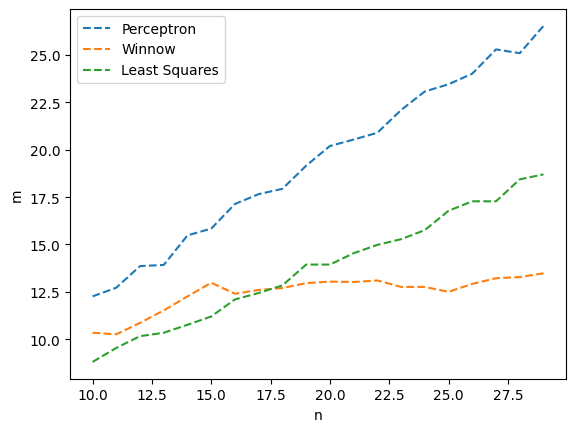

In [91]:
plt.figure()
plt.plot(range(nmin, nmax), m_req_perceptron_mean, '--', label='Perceptron')
plt.plot(range(nmin, nmax), m_req_winnow_mean, '--', label = 'Winnow')
plt.plot(range(nmin, nmax), m_req_least_squares_mean, '--', label = 'Least Squares')
# plt.plot(range(nmin, nmax), m_req_1NN_mean, '--', label = '1NN')
plt.legend()
plt.ylabel('m')
plt.xlabel('n')
plt.show()

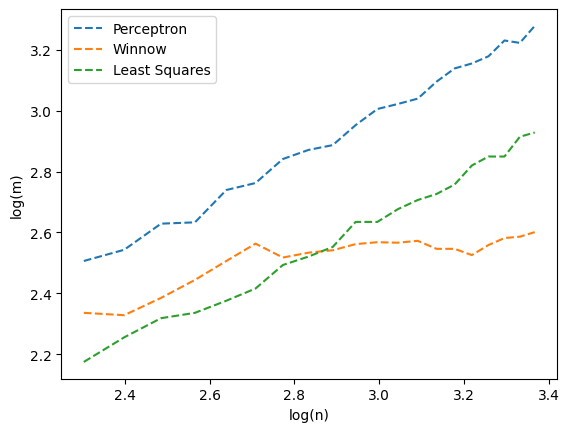

In [92]:
plt.figure()
plt.plot(np.log(range(nmin, nmax)), np.log(m_req_perceptron_mean), '--', label='Perceptron')
plt.plot(np.log(range(nmin, nmax)), np.log(m_req_winnow_mean), '--', label = 'Winnow')
plt.plot(np.log(range(nmin, nmax)), np.log(m_req_least_squares_mean), '--', label = 'Least Squares')
# plt.plot(np.log(range(nmin, nmax)), np.log(m_req_1NN_mean), '--', label = '1NN')
plt.legend()
plt.ylabel('log(m)')
plt.xlabel('log(n)')
plt.show()

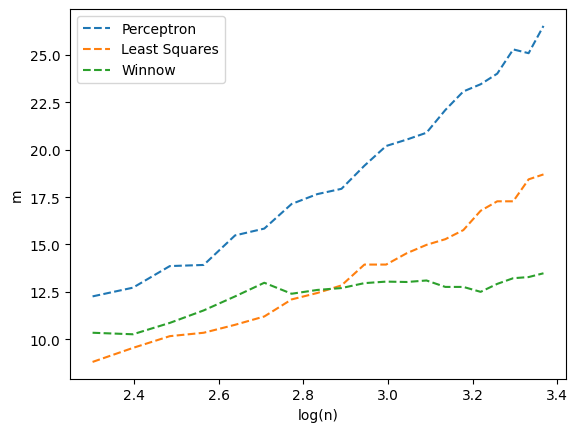

In [96]:
plt.figure()
plt.plot(np.log(range(nmin, nmax)), m_req_perceptron_mean, '--', label='Perceptron')
plt.plot(np.log(range(nmin, nmax)), m_req_least_squares_mean, '--', label = 'Least Squares')
plt.plot(np.log(range(nmin, nmax)), m_req_winnow_mean, '--', label = 'Winnow')
plt.legend()
plt.ylabel('m')
plt.xlabel('log(n)')
plt.show()